In [1]:
import os
import pandas as pd

def create_image_dataframe(base_dir='pictures'):
    data = []

    for country in os.listdir(base_dir):
        country_path = os.path.join(base_dir, country)
        if not os.path.isdir(country_path):
            continue

        for prompt_type in os.listdir(country_path):
            prompt_path = os.path.join(country_path, prompt_type)
            if not os.path.isdir(prompt_path):
                continue

            # Normalize prompt name: 'Prompt - China' -> 'China' or 'English'
            if 'English' in prompt_type:
                prompt = 'English'
            else:
                prompt = country  # The prompt is in the country's language

            for model in os.listdir(prompt_path):
                model_path = os.path.join(prompt_path, model)
                if not os.path.isdir(model_path):
                    continue

                for img_file in os.listdir(model_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                        image_path = os.path.join(model_path, img_file)
                        data.append({
                            'country': country,
                            'prompt': prompt,
                            'model': model,
                            'image_path': image_path
                        })

    df = pd.DataFrame(data)
    return df

In [2]:
import torch
from PIL import Image
from torchvision import transforms
import open_clip

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
def add_clip_embeddings(df, device):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    model = model.to(device)
    model.eval()

    clip_embeddings = []

    for path in df['image_path']:
        try:
            image = preprocess(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(image).squeeze().cpu().numpy()
        except Exception as e:
            print(f"Error processing {path}: {e}")
            embedding = None
        clip_embeddings.append(embedding)

    df['clip'] = clip_embeddings
    return df

/Users/teresaliberatore/miniconda3/envs/genai-political-portraits/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
df = pd.read_json("data_genai.json", lines=True)
df["clip"] = df["clip"].apply(lambda x: np.array(x))

In [85]:
image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)


In [86]:
import numpy as np
import torch.nn.functional as F

def compute_country_predictions(df, device=device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Get unique country names
    countries = sorted(df['country'].unique())
    #countries.append("English")
    country_texts = [f"{c}" for c in countries]  # Add context if you like

    # Encode country names as text embeddings
    with torch.no_grad():
        tokenized = tokenizer(country_texts).to(device)

        text_features = model.encode_text(tokenized)
        text_features = F.normalize(text_features, dim=-1)  # L2-normalize

    # Convert image embeddings to tensor and normalize
    image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)

    image_features = F.normalize(image_features, dim=-1)

    # Compute cosine similarity (dot product after normalization)
    similarities = image_features @ text_features.T  # shape: [num_images, num_countries]

    # Apply softmax to get probabilities
    probs = F.softmax(similarities, dim=1).cpu().numpy()

    # Get predictions and top match
    predicted_idxs = np.argmax(probs, axis=1)
    predicted_countries = [countries[i] for i in predicted_idxs]

    # Add to dataframe
    df['predicted_country'] = predicted_countries
    df['country_correct'] = df['predicted_country'] == df['country']

    return df, probs

In [87]:
def compute_politician_prediction(df, device=device):
    # Load CLIP model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model = model.to(device)
    model.eval()

    # Define class texts
    class_names = ["Photo of a politician", "Photo"]
    
    # Encode the class texts
    with torch.no_grad():
        text_tokens = tokenizer(class_names).to(device)

        text_features = model.encode_text(text_tokens)
        text_features = F.normalize(text_features, dim=-1)  # shape: [2, d]

    # Prepare image features
    image_features = torch.tensor(np.stack(df['clip'].values)).to(torch.float32).to(device)

    image_features = F.normalize(image_features, dim=-1)

    # Compute similarity scores (dot product)
    logits = image_features @ text_features.T  # shape: [N_images, 2]

    # Apply softmax across classes
    probs = F.softmax(logits, dim=-1).cpu().numpy()

    # Get predictions
    pred_indices = np.argmax(probs, axis=1)
    predicted_labels = [class_names[i] for i in pred_indices]

    # Store results
    # df['politician_prob'] = probs[:, 0]
    # df['other_prob'] = probs[:, 1]
    df['predicted_label'] = predicted_labels
    df['politician'] = df['predicted_label'] == "Photo of a politician"

    return df

In [88]:
df, probs = compute_country_predictions(df)
df = compute_politician_prediction(df)

accuracy = df['country_correct'].mean()
print(f"Prediction accuracy: {accuracy:.2%}")

/Users/teresaliberatore/miniconda3/envs/genai-political-portraits/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
/Users/teresaliberatore/miniconda3/envs/genai-political-portraits/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Prediction accuracy: 76.74%


In [89]:
df = compute_politician_prediction(df)

/Users/teresaliberatore/miniconda3/envs/genai-political-portraits/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [102]:
def compute_accuracy_tables(df):
    acc_by_country = df.groupby('country')[['country_correct', 'politician']].mean().reset_index()
    acc_by_model = df.groupby('model')[['country_correct', 'politician']].mean().reset_index()
    acc_by_prompt = df.groupby('prompt')[['country_correct', 'politician']].mean().reset_index()
    acc_by_all = df.groupby(["combo_label"])[['country_correct', 'politician']].mean().reset_index()
    
    return acc_by_country, acc_by_model, acc_by_prompt, acc_by_all

df["combo_label"] = df["country"].str.replace("China", "CN").str.replace("Italy", "IT").str.replace("Netherlands", "NL") + " | " + df["prompt"].str.replace("China", "Chinese").str.replace("Italy", "Italian").str.replace("Netherlands", "Dutch") + " | " + df["model"].str.replace("OpenAI", "DALL-E")
acc_by_country, acc_by_model, acc_by_prompt, acc_by_all = compute_accuracy_tables(df)

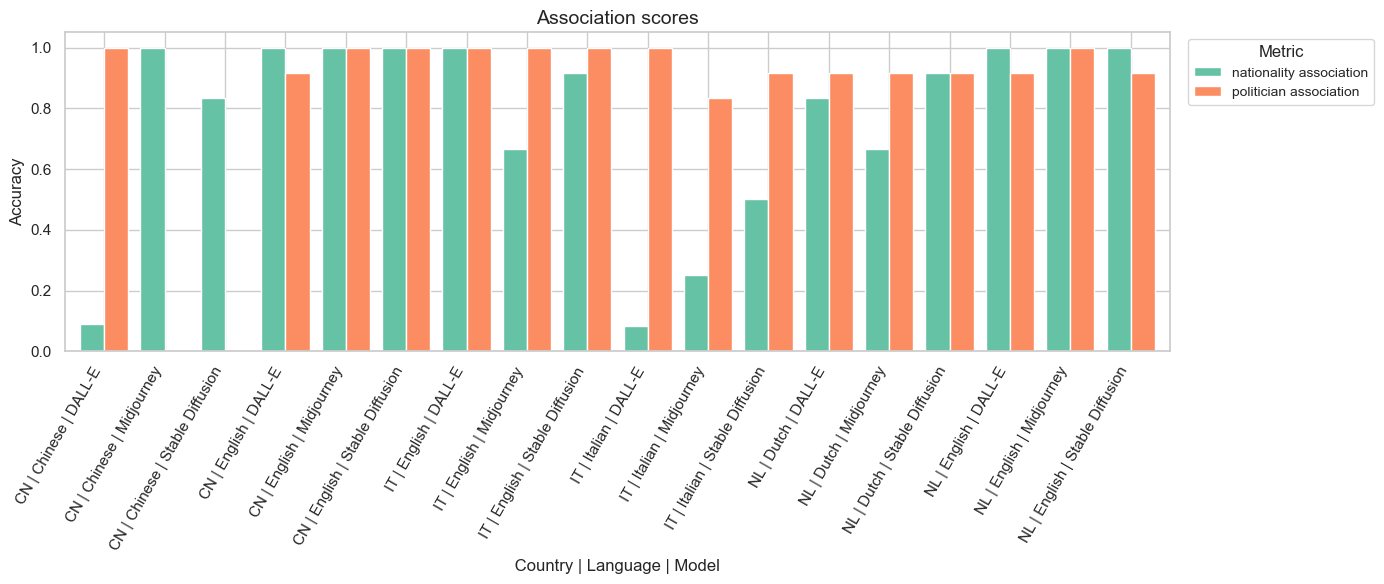

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_association_scores(acc_by_all):
# Set style and palette
    sns.set(style="whitegrid")
    custom_palette = sns.color_palette("Set2")
    acc_by_all = acc_by_all.rename(columns={"country_correct": "nationality association", "politician": "politician association"})
    # Sort the data
    #acc_sorted = acc_by_all.sort_values(by="country accuracy")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot with correct alignment
    acc_by_all.plot(
        kind="bar",
        x="combo_label",
        ax=ax,
        color=custom_palette,
        width=0.8
    )

    # Fix label alignment
    ax.set_xticks(range(len(acc_by_all)))
    ax.set_xticklabels(acc_by_all["combo_label"], rotation=60, ha="right")

    # Axis labels and title
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_xlabel(" Country | Language | Model ", fontsize=12)
    ax.set_title("Association scores", fontsize=14)

    # Legend outside
    ax.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()
    plt.savefig("results/association_scores.png")

In [98]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def reduce_embeddings(df, method='umap'):
    image_embs = np.stack(df['clip'].values)
    reducer = {
        'umap': umap.UMAP(metric="cosine", random_state=5),
        'tsne': TSNE(n_components=2, random_state=42),
        'pca': PCA(n_components=2)
    }[method]

    reduced = reducer.fit_transform(image_embs)
    df['x'] = reduced[:, 0]
    df['y'] = reduced[:, 1]
    return df

In [93]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np
import matplotlib.patches as mpatches

def plot_embeddings_with_double_borders(df, figsize=(20, 15), dot_size=100):
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in df.iterrows():
        x, y = row['x'], row['y']
        img_path = row['image_path']
        country_correct = row.get('country_correct', True)
        politician_correct = row.get('politician', True)

        # Define colors
        inner_color = 'green' if country_correct else 'red'
        outer_color = 'blue' if politician_correct else 'orange'

        try:
            img = Image.open(img_path)
            img.thumbnail((50, 50))
            imagebox = OffsetImage(img, zoom=1)

            # Outer box (politician) - slightly bigger
            outer_ab = AnnotationBbox(
                imagebox, (x, y),
                bboxprops=dict(edgecolor=outer_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(outer_ab)

            # Inner box (country) - on top, slightly smaller image
            inner_img = img.copy()
            inner_img.thumbnail((40, 40))
            inner_imagebox = OffsetImage(inner_img, zoom=1)
            inner_ab = AnnotationBbox(
                inner_imagebox, (x, y),
                bboxprops=dict(edgecolor=inner_color, linewidth=1.5),
                frameon=True
            )
            ax.add_artist(inner_ab)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    # Optional: base scatter just for layout reference
    ax.scatter(df['x'], df['y'],
               c=df['country'].astype('category').cat.codes,
               cmap='tab20', alpha=0.05, s=dot_size)

    # Legend
    legend_elements = [
        mpatches.Patch(color='green', label='Country correct'),
        mpatches.Patch(color='red', label='Country wrong'),
        mpatches.Patch(color='blue', label='Politician correct'),
        mpatches.Patch(color='orange', label='Politician wrong'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

    ax.set_title('UMAP of CLIP Embedding Space – Highlighting Country & Politician Accuracy', fontsize=16)
    #ax.axis('off')
    plt.tight_layout()
    plt.show()

/Users/teresaliberatore/miniconda3/envs/genai-political-portraits/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


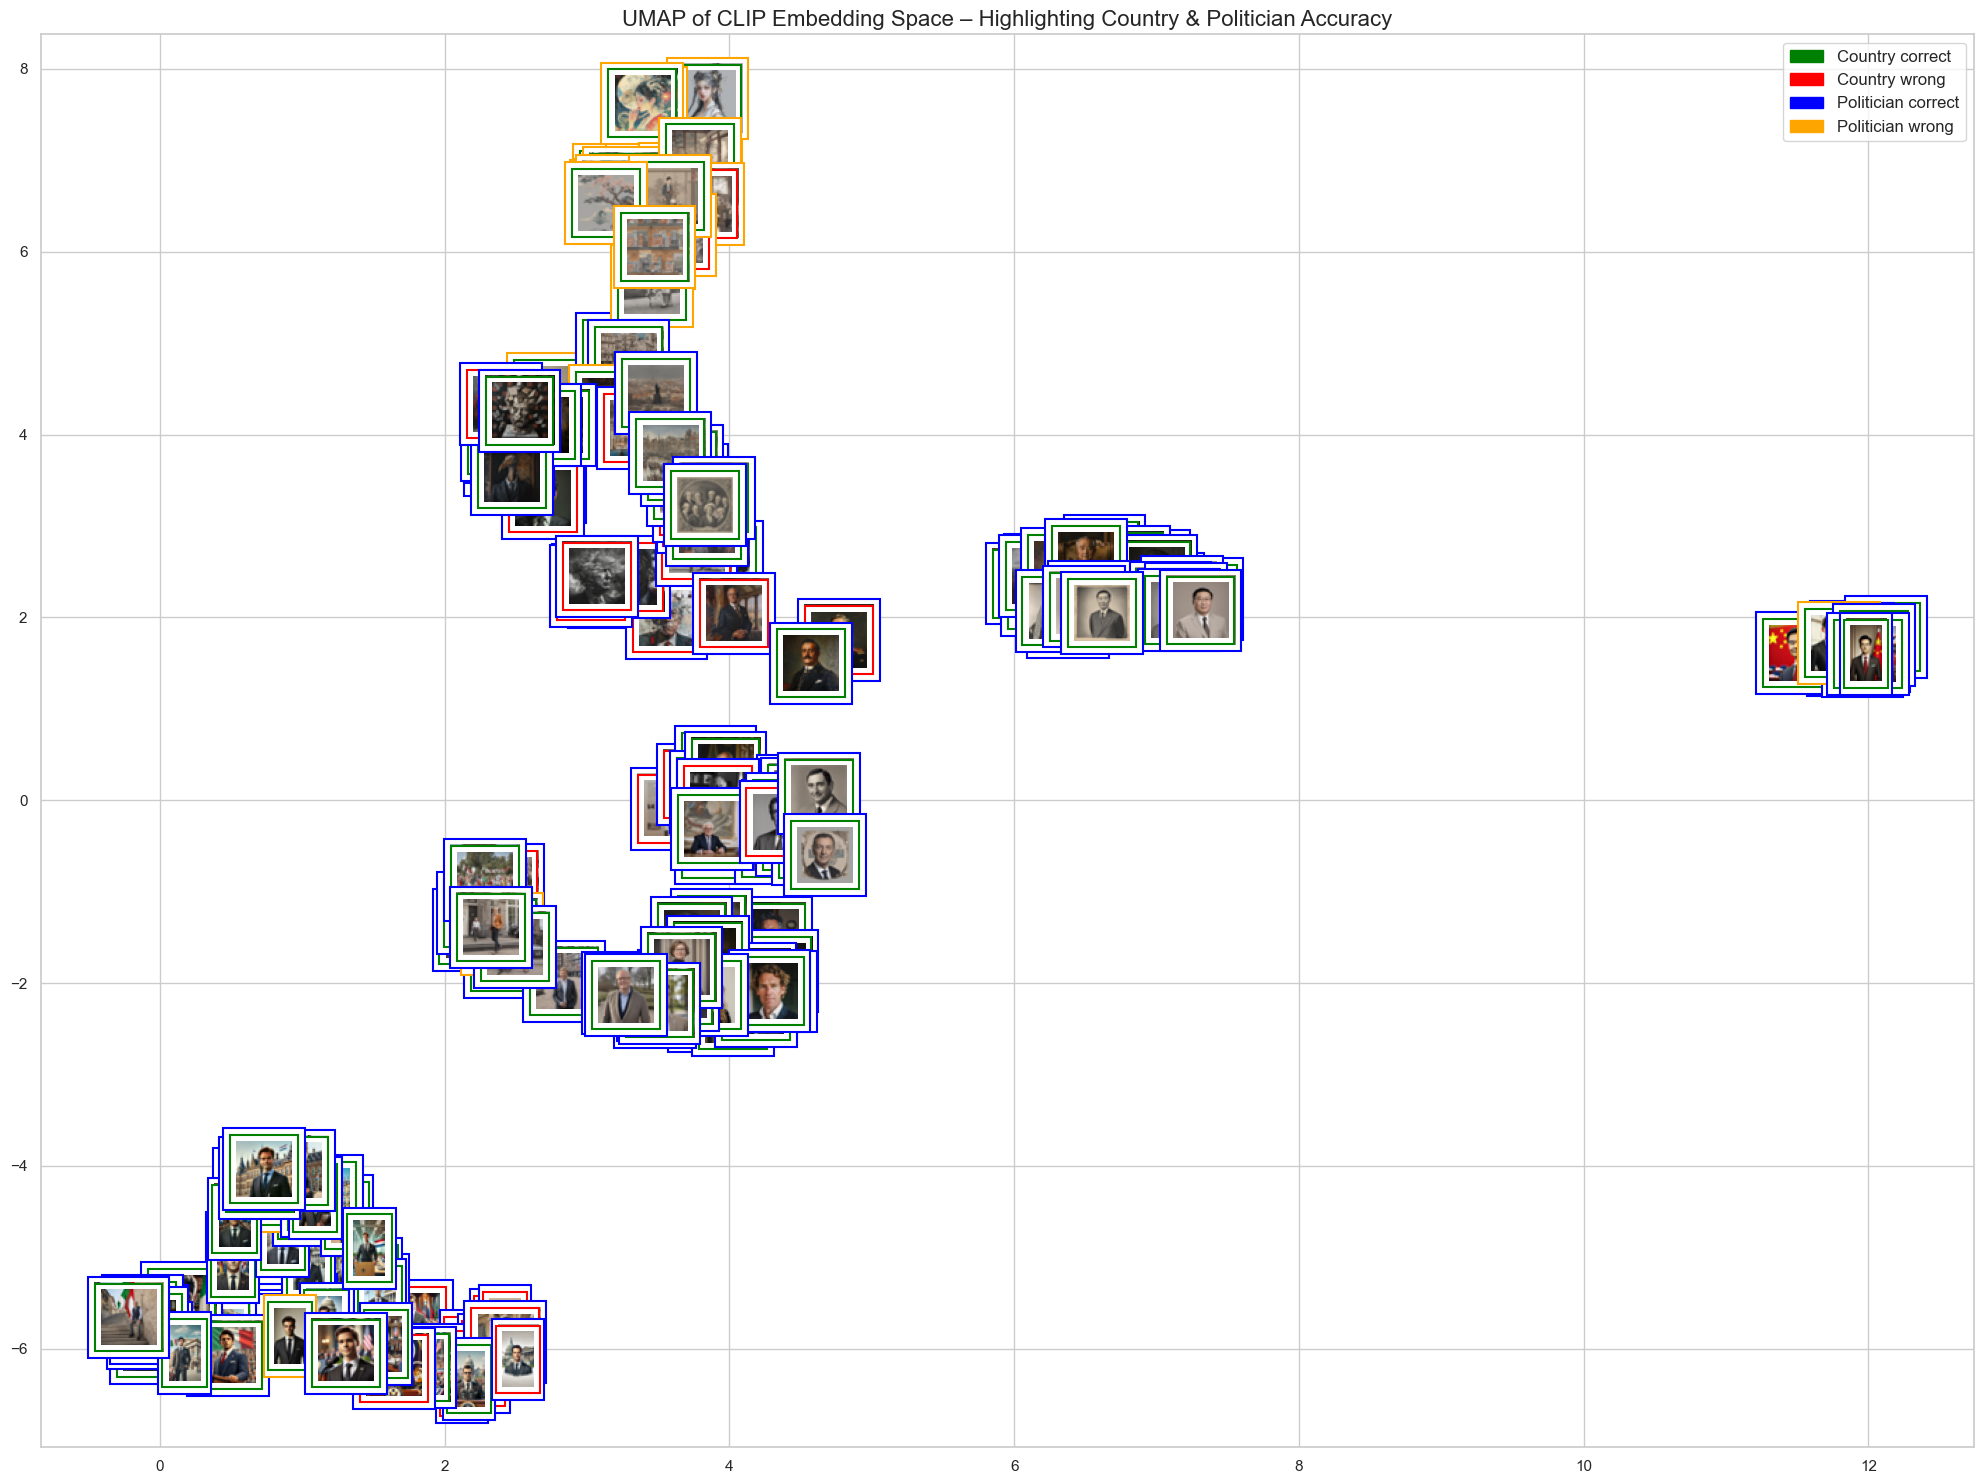

In [99]:
df = reduce_embeddings(df, method='umap')
plot_embeddings_with_double_borders(df)

In [ ]:
def plot_clusters(df):
    

In [96]:
from sklearn.metrics import silhouette_score
import numpy as np

X = np.vstack(df["clip"].values)  # shape (n_samples, n_features)

# For each grouping, encode labels numerically
from sklearn.preprocessing import LabelEncoder

def silhouette_by_label(col_name):
    labels = LabelEncoder().fit_transform(df[col_name])
    score = silhouette_score(X, labels, metric='cosine')  # cosine distance fits CLIP
    print(f"Silhouette score for {col_name}: {score:.4f}")
    return score

silhouette_by_label("country")
silhouette_by_label("prompt")
silhouette_by_label("model")
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_by_label("combo_label")


Silhouette score for country: 0.0835
Silhouette score for prompt: 0.0705
Silhouette score for model: 0.1422
Silhouette score for combo_label: 0.1303


0.13033862389761985

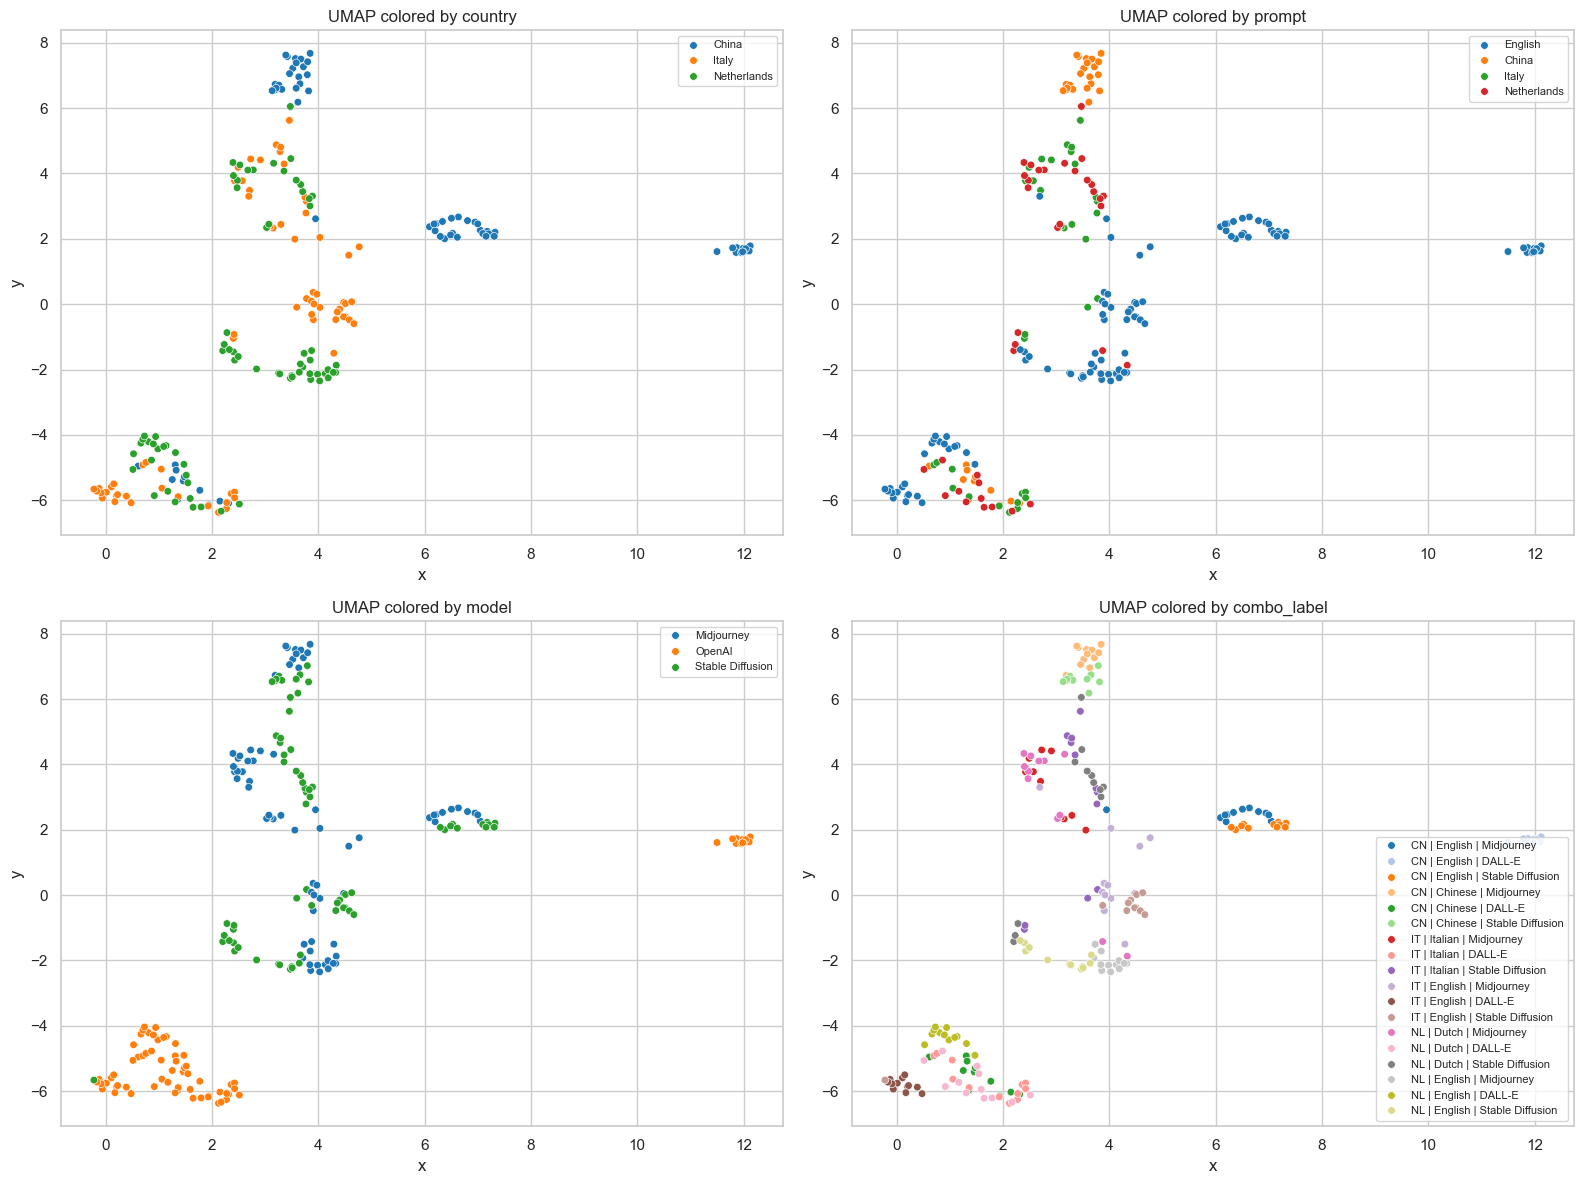

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(df):

    # Visualize by country, prompt, model, or combo
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
        if col == "combo_label":
            sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab20", s=30)
        else:
            
            sns.scatterplot(data=df, x="x", y="y", hue=col, ax=ax, palette="tab10", s=30)
        ax.set_title(f"UMAP colored by {col}")
        ax.legend(loc="best", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.savefig("results/embeddings_umap_clusters.png")

In [28]:
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    label_names = le.inverse_transform(np.unique(labels))

    # Get silhouette scores for each sample
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    # Add to dataframe for aggregation
    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)

    print(f"\n📊 Average silhouette scores per '{label_col}' value:\n")
    print(avg_scores)

    return avg_scores, df_sil

In [29]:
# Score per country
silhouette_scores_per_value(df, "country")

# Score per prompt
silhouette_scores_per_value(df, "prompt")

# Score per model
silhouette_scores_per_value(df, "model")

# Score per combo of all three
df["combo_label"] = df["country"] + "_" + df["prompt"] + "_" + df["model"]
silhouette_scores_per_value(df, "combo_label")


📊 Average silhouette scores per 'country' value:

country
China          0.134307
Italy          0.073296
Netherlands    0.043675
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'prompt' value:

prompt
China          0.141555
English        0.100172
Italy          0.030019
Netherlands   -0.047269
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'model' value:

model
OpenAI              0.355552
Midjourney          0.056796
Stable Diffusion    0.017306
Name: silhouette, dtype: float32

📊 Average silhouette scores per 'combo_label' value:

combo_label
China_English_OpenAI                        0.494738
China_English_Stable Diffusion              0.403109
Italy_English_OpenAI                        0.337727
Netherlands_English_OpenAI                  0.256935
China_China_Midjourney                      0.248037
Netherlands_English_Midjourney              0.246562
Italy_English_Stable Diffusion              0.195369
China_China_Stable Diffusion         

(combo_label
 China_English_OpenAI                        0.494738
 China_English_Stable Diffusion              0.403109
 Italy_English_OpenAI                        0.337727
 Netherlands_English_OpenAI                  0.256935
 China_China_Midjourney                      0.248037
 Netherlands_English_Midjourney              0.246562
 Italy_English_Stable Diffusion              0.195369
 China_China_Stable Diffusion                0.146874
 Italy_Italy_Midjourney                      0.085855
 China_English_Midjourney                    0.059807
 Netherlands_English_Stable Diffusion        0.049832
 Netherlands_Netherlands_Stable Diffusion    0.015023
 China_China_OpenAI                          0.009647
 Italy_Italy_OpenAI                         -0.008481
 Italy_Italy_Stable Diffusion               -0.010775
 Italy_English_Midjourney                   -0.016537
 Netherlands_Netherlands_OpenAI             -0.080281
 Netherlands_Netherlands_Midjourney         -0.097402
 Name: silhouet

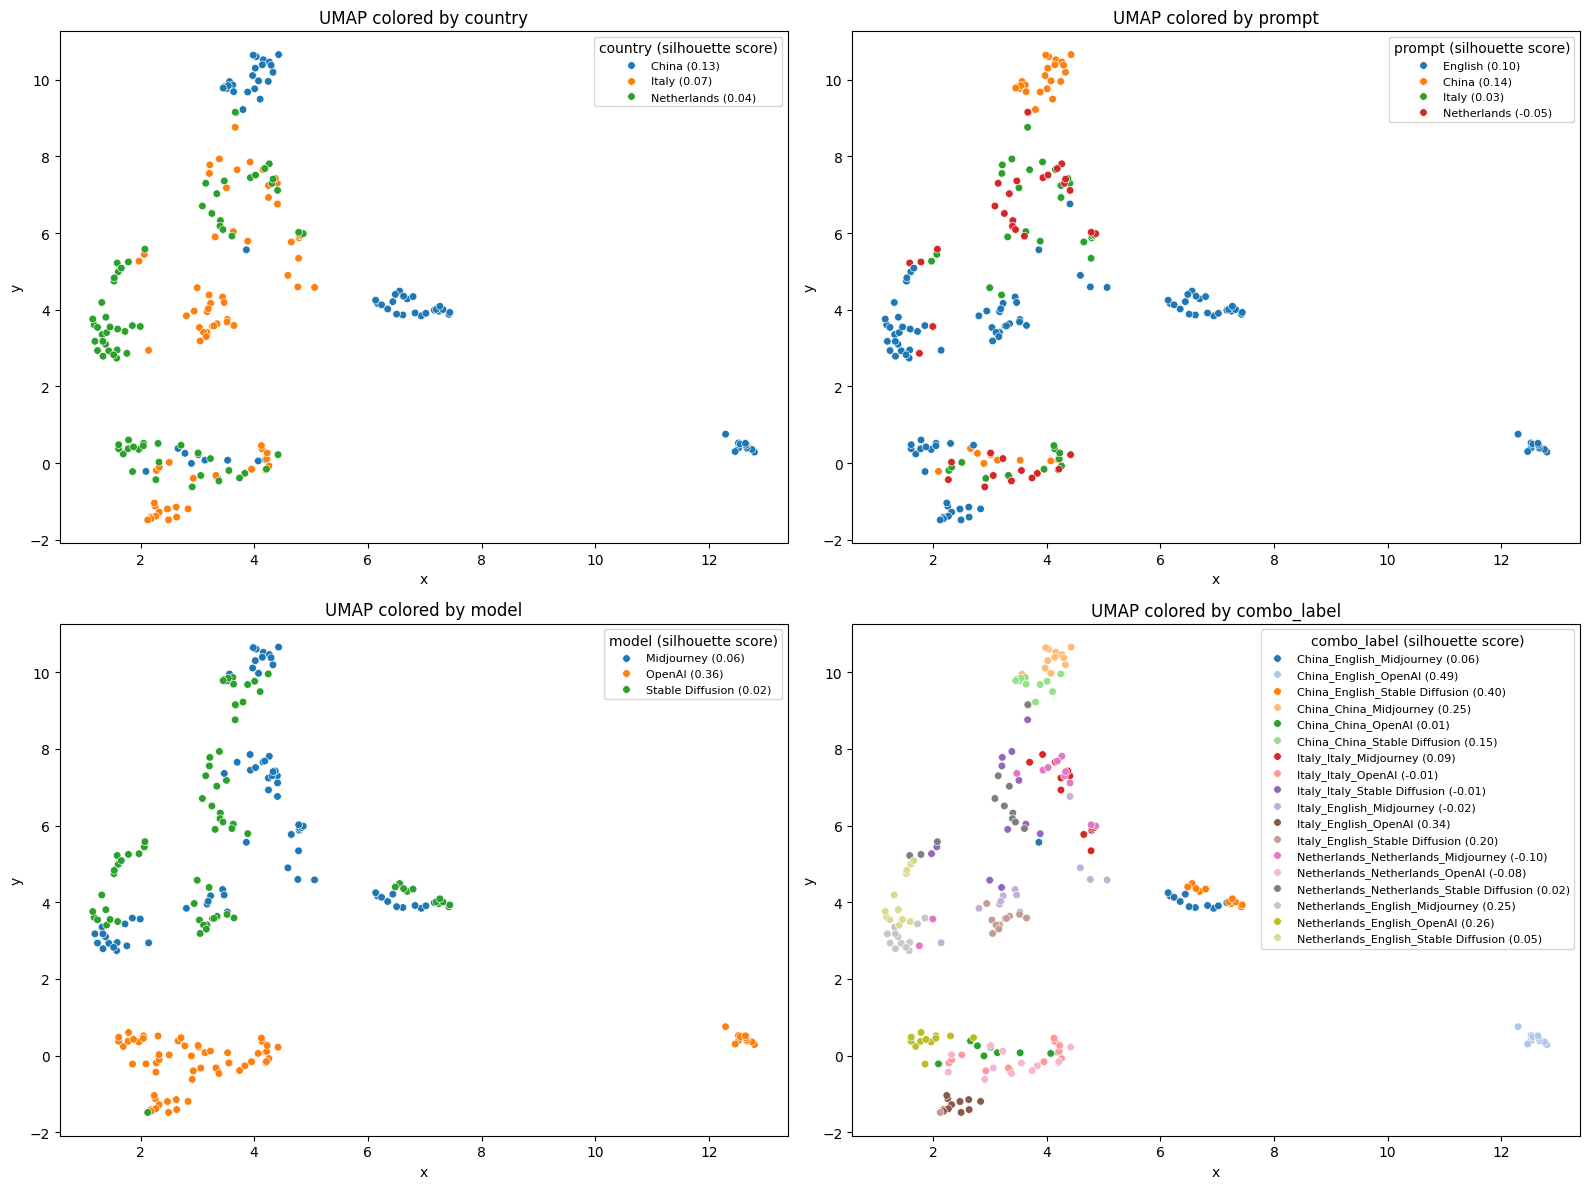

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)
    return avg_scores, df_sil

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    avg_scores, df_sil = silhouette_scores_per_value(df, col)

    # Create a mapping from original label to label with silhouette score
    score_map = {label: f"{label} ({score:.2f})" for label, score in avg_scores.items()}

    # Create a new column for the label with silhouette score for plotting
    df_sil[f"{col}_with_score"] = df_sil[col].map(score_map)

    # Choose palette
    palette = "tab20" if col == "combo_label" else "tab10"

    # Plot
    sns.scatterplot(data=df_sil, x="x", y="y", hue=f"{col}_with_score", ax=ax, palette=palette, s=30)
    ax.set_title(f"UMAP colored by {col}")
    ax.legend(loc="best", fontsize=8, title=f"{col} (silhouette score)")

plt.tight_layout()
plt.show()

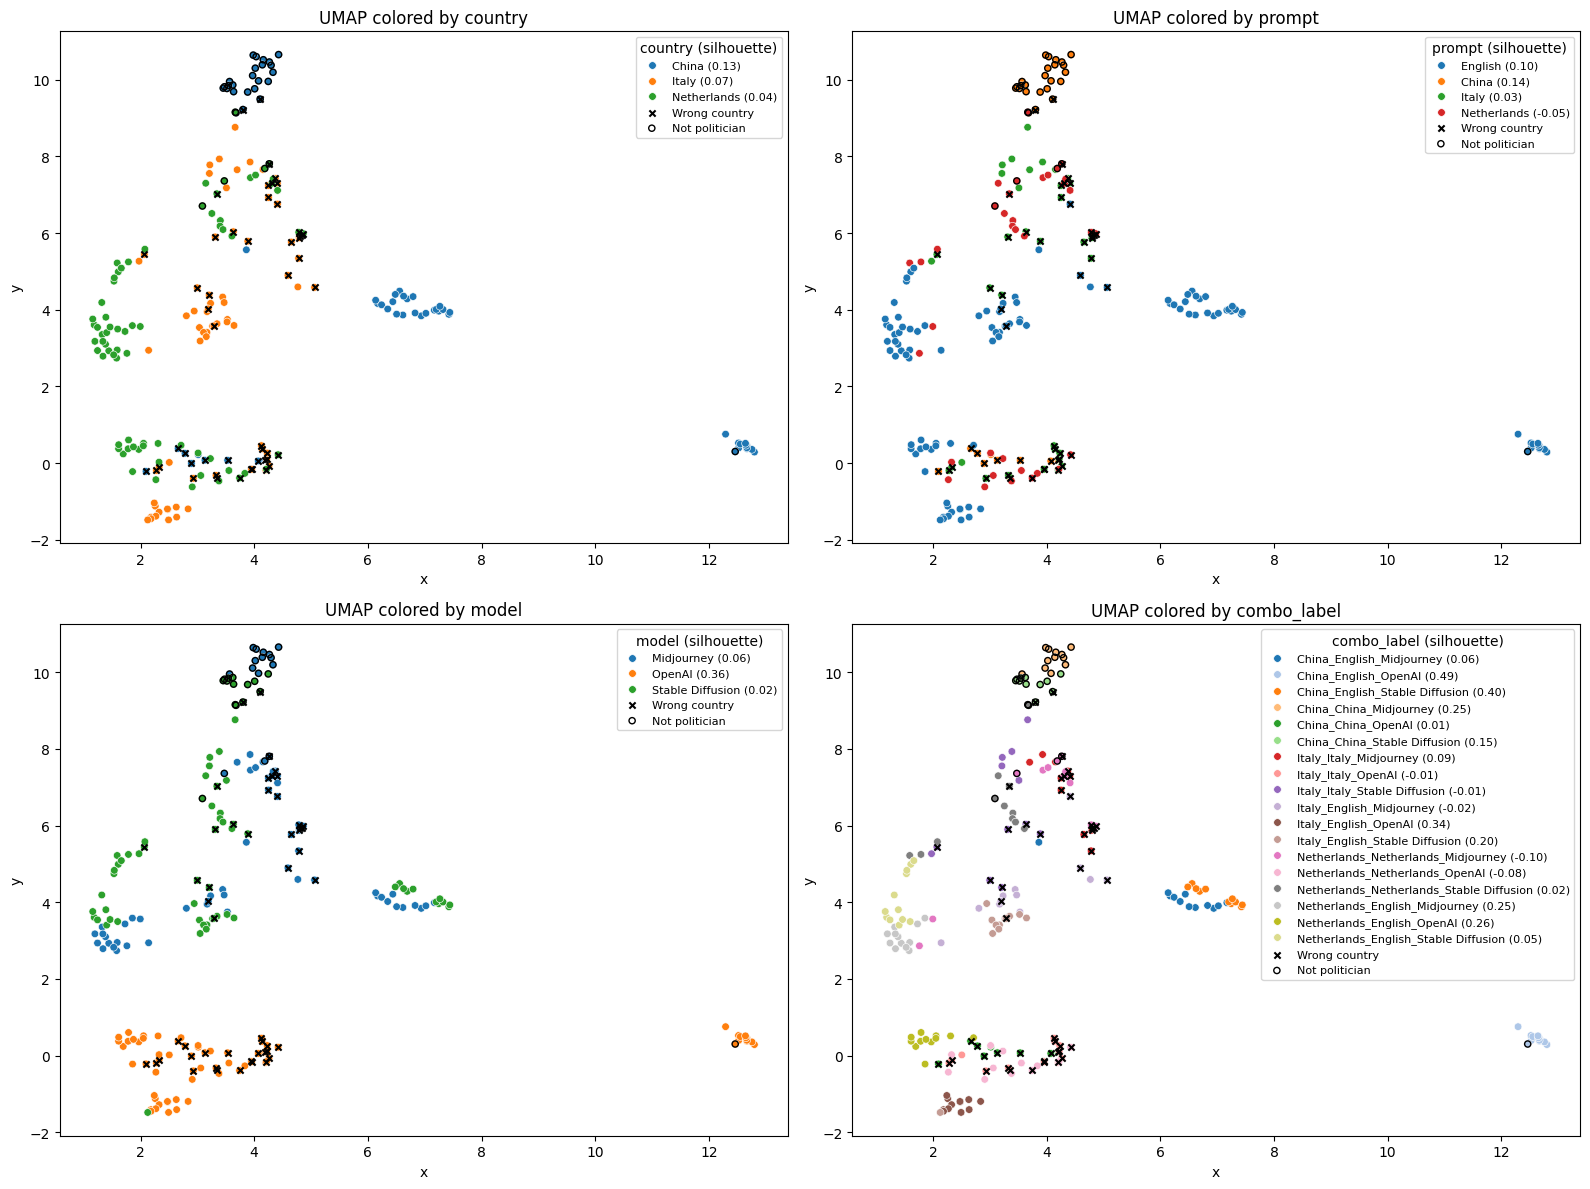

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.lines as mlines

def silhouette_scores_per_value(df, label_col, embedding_col="clip"):
    X = np.vstack(df[embedding_col].values)
    le = LabelEncoder()
    labels = le.fit_transform(df[label_col])
    sample_silhouette = silhouette_samples(X, labels, metric='cosine')

    df_sil = df.copy()
    df_sil["silhouette"] = sample_silhouette
    avg_scores = df_sil.groupby(label_col)["silhouette"].mean().sort_values(ascending=False)
    return avg_scores, df_sil

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, col in zip(axes.flat, ["country", "prompt", "model", "combo_label"]):
    avg_scores, df_sil = silhouette_scores_per_value(df, col)

    # Add silhouette score to labels
    score_map = {label: f"{label} ({score:.2f})" for label, score in avg_scores.items()}
    df_sil[f"{col}_with_score"] = df_sil[col].map(score_map)

    # Choose palette
    palette = "tab20" if col == "combo_label" else "tab10"

    # Main scatterplot
    sns.scatterplot(data=df_sil, x="x", y="y", hue=f"{col}_with_score", ax=ax, palette=palette, s=30, legend=True)

    # Overlay tiny black crosses for incorrect country
    wrong_country = df_sil[df_sil["country_correct"] == False]
    ax.scatter(wrong_country["x"], wrong_country["y"], color="black", marker="x", s=20, label="Wrong country")

    # Overlay tiny black circles for non-politicians
    not_politician = df_sil[df_sil["politician"] == False]
    ax.scatter(not_politician["x"], not_politician["y"], facecolors='none', edgecolors="black", marker="o", s=20, label="Not politician")

    # Title and legend
    ax.set_title(f"UMAP colored by {col}")

    # Build custom legend
    handles, labels = ax.get_legend_handles_labels()

    # Add marker legends manually if missing
    cross = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=11, label='Wrong country')
    circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=11, markerfacecolor='none', label='Not politician')

    # handles += [cross, circle]
    # labels += ['Wrong country', 'Not politician']

    ax.legend(handles=handles, labels=labels, loc="best", fontsize=8, title=f"{col} (silhouette)")

plt.tight_layout()
plt.show()